In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Part1 - creating the dataset

In [2]:
# importing the dataset
# index_col = number --> the index will be the column number provided
# parse_dates --> will change the index to datetime object
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv', index_col=0, parse_dates=True)

In [4]:
df.columns

Index(['S4248SM144NCEN'], dtype='object')

In [5]:
len(df)

325

In [8]:
# remove the na values if have
# another approache- fill te na places with mean value for example
df = df.dropna()

In [7]:
len(df)

325

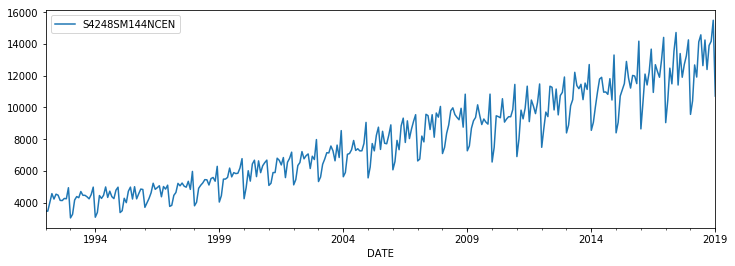

In [9]:
df.plot(figsize=(12,4))

In [10]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [11]:
y = df['S4248SM144NCEN'].values.astype(float)
y

array([ 3459.,  3458.,  4002.,  4564.,  4221.,  4529.,  4466.,  4137.,
        4126.,  4259.,  4240.,  4936.,  3031.,  3261.,  4160.,  4377.,
        4307.,  4696.,  4458.,  4457.,  4364.,  4236.,  4500.,  4974.,
        3075.,  3377.,  4443.,  4261.,  4460.,  4985.,  4324.,  4719.,
        4374.,  4248.,  4784.,  4971.,  3370.,  3484.,  4269.,  3994.,
        4715.,  4974.,  4223.,  5000.,  4235.,  4554.,  4851.,  4826.,
        3699.,  3983.,  4262.,  4619.,  5219.,  4836.,  4941.,  5062.,
        4365.,  5012.,  4850.,  5097.,  3758.,  3825.,  4454.,  4635.,
        5210.,  5057.,  5231.,  5034.,  4970.,  5342.,  4831.,  5965.,
        3796.,  4019.,  4898.,  5090.,  5237.,  5447.,  5435.,  5107.,
        5515.,  5583.,  5346.,  6286.,  4032.,  4435.,  5479.,  5483.,
        5587.,  6176.,  5621.,  5889.,  5828.,  5849.,  6180.,  6771.,
        4243.,  4952.,  6008.,  5353.,  6435.,  6673.,  5636.,  6630.,
        5887.,  6322.,  6520.,  6678.,  5082.,  5216.,  5893.,  5894.,
      

In [12]:
# creating test size of one year/12 months
test_size = 12

In [13]:
# splitting the datta into test and train set
train_set = y[:-test_size]
test_set = y[-test_size:]

In [14]:
test_set

array([10415., 12683., 11919., 14138., 14583., 12640., 14257., 12396.,
       13914., 14174., 15504., 10718.])

In [16]:
# we want to normalize our dataset
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler(feature_range=(-1,1))

In [18]:
# the normalization will be dependent ONLY on the train_set, so we won't have leakages from the test_set
scaler.fit(train_set.reshape(-1,1)) # this data will be copied into 'scaler' for the next row

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [20]:
train_norm = scaler.transform(train_set.reshape(-1,1))

In [25]:
window_size = 12 # 12 months
len(y) - test_size - window_size # this will be the actual training set length

301

In [26]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [29]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        win = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((win,label))
        
    return out

In [30]:
train_data = input_data(train_norm, window_size)

In [31]:
# validate agains the first calculation
len(train_data)

301

In [32]:
train_data[0]

(tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
         -0.8128, -0.7901, -0.7933, -0.6743]),
 tensor([-1.]))

## Part2- model, training and evaluaion

In [33]:
# definning the model
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [35]:
torch.manual_seed(101)
model = LSTMnetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [39]:
import time 
start = time.time()
# train the model
epochs = 100

for i in range(epochs):
    for seq,y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        loss = criterion(y_pred,y_train)
        
        loss.backward()
        optimizer.step()
    print(f'Epoch {i} Loss {loss.item()}')

print((time.time()-start)/60)

Epoch 0 Loss 0.25314345955848694
Epoch 1 Loss 0.37523898482322693
Epoch 2 Loss 0.3901209831237793
Epoch 3 Loss 0.349496990442276
Epoch 4 Loss 0.3307788074016571
Epoch 5 Loss 0.3323073089122772
Epoch 6 Loss 0.3266769051551819
Epoch 7 Loss 0.32077038288116455
Epoch 8 Loss 0.3065176010131836
Epoch 9 Loss 0.2951700687408447
Epoch 10 Loss 0.26913928985595703
Epoch 11 Loss 0.25979408621788025
Epoch 12 Loss 0.2459997683763504
Epoch 13 Loss 0.2222774624824524
Epoch 14 Loss 0.18593749403953552
Epoch 15 Loss 0.18445566296577454
Epoch 16 Loss 0.17432530224323273
Epoch 17 Loss 0.2582225203514099
Epoch 18 Loss 0.2242051064968109
Epoch 19 Loss 0.23121914267539978
Epoch 20 Loss 0.19758883118629456
Epoch 21 Loss 0.18989050388336182
Epoch 22 Loss 0.2104491889476776
Epoch 23 Loss 0.16945958137512207
Epoch 24 Loss 0.14590860903263092
Epoch 25 Loss 0.11834970861673355
Epoch 26 Loss 0.0001621616684133187
Epoch 27 Loss 0.0064497096464037895
Epoch 28 Loss 0.050497524440288544
Epoch 29 Loss 0.0127326799556612

In [45]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-window_size:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [46]:
preds

[0.2686554491519928,
 0.6155226826667786,
 0.4462774693965912,
 0.7974185943603516,
 1.0,
 0.43345585465431213,
 0.772972047328949,
 0.5173946619033813,
 0.6548423171043396,
 0.7488674521446228,
 0.9205060005187988,
 0.11684759706258774,
 0.21764472126960754,
 0.7362536787986755,
 0.42575034499168396,
 0.8574904799461365,
 1.24961256980896,
 0.32853081822395325,
 0.8707497715950012,
 0.6814860105514526,
 0.601524293422699,
 0.9176154732704163,
 0.8960760235786438,
 0.18404555320739746]

In [47]:
#we want to denormalize the predictions
denorm_preds = scaler.inverse_transform(np.array(preds[-window_size:]).reshape(-1,1))

In [48]:
denorm_preds

array([[10153.61279707],
       [13187.21589413],
       [11370.92664303],
       [13896.39056244],
       [16190.1087271 ],
       [10802.2410212 ],
       [13973.95078894],
       [12866.85241872],
       [12399.11635438],
       [14248.0917109 ],
       [14122.09669992],
       [ 9957.07446349]])

In [50]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [51]:
# working to plot the data- the x axis
x = np.arange('2018-02-01','2019-02-02',dtype='datetime64[M]')

In [52]:
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

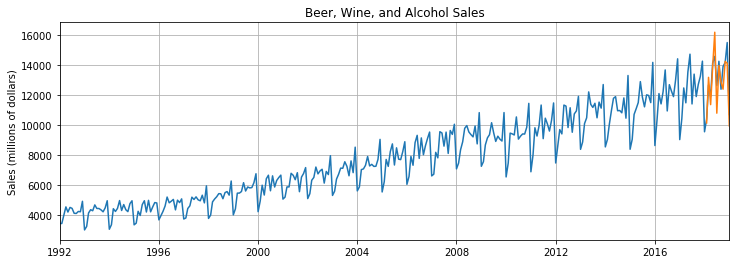

In [55]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,denorm_preds)
plt.show()

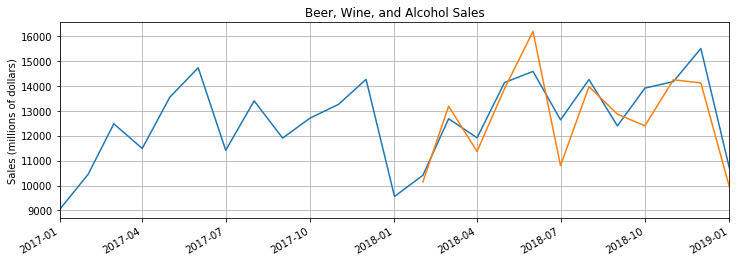

In [58]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':]) # this is the slicing causing the graph zoom from 2017
plt.plot(x,denorm_preds)
plt.show()

In [59]:
epochs = 100

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.01454567
Epoch:  2 Loss: 0.01350383
Epoch:  3 Loss: 0.02643331
Epoch:  4 Loss: 0.01324219
Epoch:  5 Loss: 0.01439027
Epoch:  6 Loss: 0.01231953
Epoch:  7 Loss: 0.01169418
Epoch:  8 Loss: 0.01061528
Epoch:  9 Loss: 0.00724249
Epoch: 10 Loss: 0.00424754
Epoch: 11 Loss: 0.00208558
Epoch: 12 Loss: 0.00440567
Epoch: 13 Loss: 0.01001350
Epoch: 14 Loss: 0.00601961
Epoch: 15 Loss: 0.00487102
Epoch: 16 Loss: 0.00251737
Epoch: 17 Loss: 0.00400521
Epoch: 18 Loss: 0.00497501
Epoch: 19 Loss: 0.00461044
Epoch: 20 Loss: 0.00193556
Epoch: 21 Loss: 0.00038231
Epoch: 22 Loss: 0.00528781
Epoch: 23 Loss: 0.00042755
Epoch: 24 Loss: 0.00195656
Epoch: 25 Loss: 0.00191549
Epoch: 26 Loss: 0.00084451
Epoch: 27 Loss: 0.00021586
Epoch: 28 Loss: 0.00923860
Epoch: 29 Loss: 0.00273661
Epoch: 30 Loss: 0.00330967
Epoch: 31 Loss: 0.00159039
Epoch: 32 Loss: 0.00249826
Epoch: 33 Loss: 0.00335327
Epoch: 34 Loss: 0.00662615
Epoch: 35 Loss: 0.00236142
Epoch: 36 Loss: 0.00001399
Epoch: 37 Loss: 0.00416735
E

In [61]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [62]:
denorm_preds = scaler.inverse_transform(np.array(preds[-window_size:]).reshape(-1,1))

In [64]:
denorm_preds

array([[11475.87320378],
       [13219.57496449],
       [13064.54991925],
       [14286.57704863],
       [14683.14970282],
       [12980.41568461],
       [14580.76417348],
       [13902.12037846],
       [15359.38509566],
       [15499.6995208 ],
       [16414.82506508],
       [12745.13757885]])

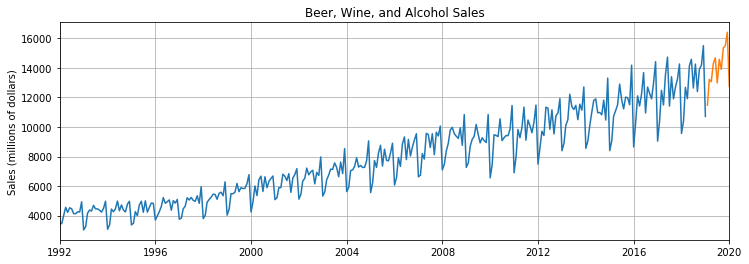

In [70]:
x = np.arange('2019-02-01','2020-02-02',dtype='datetime64[M]')

plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,denorm_preds)
plt.show()

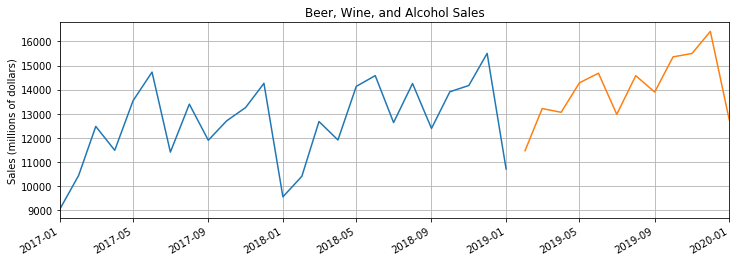

In [71]:
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':]) # this is the slicing causing the graph zoom from 2017
plt.plot(x,denorm_preds)
plt.show()